In [1]:
%pip install tensorflow numpy matplotlib scikit-learn pandas

     ---------------------------------------- 12.9/12.9 MB 4.3 MB/s eta 0:00:00
     ---------------------------------------- 7.8/7.8 MB 4.1 MB/s eta 0:00:00
     ---------------------------------------- 11.0/11.0 MB 4.6 MB/s eta 0:00:00
     ---------------------------------------- 11.6/11.6 MB 4.2 MB/s eta 0:00:00
     -------------------------------------- 390.0/390.0 MB 3.3 MB/s eta 0:00:00
     ---------------------------------------- 3.0/3.0 MB 6.4 MB/s eta 0:00:00
     ---------------------------------------- 64.9/64.9 kB ? eta 0:00:00
     -------------------------------------- 126.6/126.6 kB 3.8 MB/s eta 0:00:00
     ---------------------------------------- 1.2/1.2 MB 6.3 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 1.0 MB/s eta 0:00:00
     ---------------------------------------- 5.5/5.5 MB 6.4 MB/s eta 0:00:00
     ---------------------------------------- 26.4/26.4 MB 6.2 MB/s eta 0:00:00
     ---------------------------------------- 15.9/15.9


[notice] A new release of pip available: 22.2.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image as imageTf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models
from keras import Sequential, layers
from keras.applications import VGG16
from keras.regularizers import l2
from keras.optimizers import Adam
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [33]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [4]:
train_dir = 'data/train'
val_dir = 'data/valid'
test_dir = 'data/test'

image_size = 128
batch_size = 32
epoch = 20

In [5]:
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

val_dataset = image_dataset_from_directory(
    val_dir,
    image_size=(image_size, image_size),
    batch_size=image_size
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(image_size, image_size),
    batch_size=image_size
)

Found 3570 files belonging to 5 classes.
Found 428 files belonging to 5 classes.
Found 204 files belonging to 5 classes.


In [7]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)
# train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
# val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
# test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

train_dataset = train_dataset.map(lambda x, y: (x, y))
val_dataset = val_dataset.map(lambda x, y: (x, y))
test_dataset = test_dataset.map(lambda x, y: (x, y))


In [8]:
class_names = os.listdir(train_dir)

class_names = [name for name in class_names if os.path.isdir(os.path.join(train_dir, name))]

print(class_names)

['Black Soil', 'Cinder Soil', 'Laterite Soil', 'Peat Soil', 'Yellow Soil']


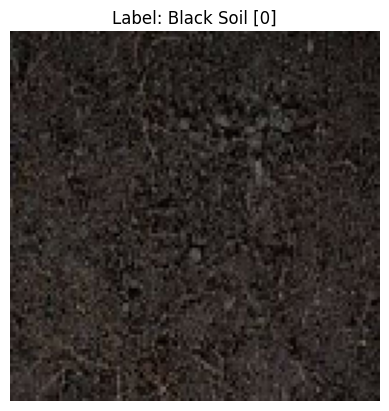

In [ ]:
for images, labels in train_dataset.take(1):  # Take one batch
    imag0e = images[0].numpy()  # Get the first image as a NumPy array
    label = labels[0].numpy()  # Get the corresponding label
    break

# Plot the image
plt.imshow(image)  # `image` is already scaled to [0, 1]
plt.title(f'Label: {class_names[label]} [{label}]')
plt.axis('off')
plt.show()

In [11]:
class_names[0]

'Black Soil'

In [ ]:
# vgg16_base = VGG16(
#     include_top=False,  # Exclude the default classifier head
#     weights="imagenet",  # Use ImageNet weights
#     input_shape=(image_size, image_size, 3),  # Input shape
#     pooling="avg"  # Global average pooling for feature extraction
# )

# # Freeze the pre-trained base to retain its weights during training
# vgg16_base.trainable = False

In [ ]:
model = Sequential([
    layers.Input(shape=(image_size, image_size, 3)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Flatten(),
    
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.2),
    
    layers.Dense(len(class_names), activation='softmax')
])

optimizer = Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 899,429 (3.43 MB)

 Trainable params: 899,429 (3.43 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6
)

In [17]:
history = model.fit(
    train_dataset, 
    epochs=epoch, 
    validation_data=val_dataset, 
    callbacks=[lr_scheduler]
)

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 51s 439ms/step - accuracy: 0.5061 - loss: 3.4897 - val_accuracy: 0.7056 - val_loss: 1.9535 - learning_rate: 1.0000e-04
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 45s 395ms/step - accuracy: 0.7317 - loss: 1.8144 - val_accuracy: 0.8154 - val_loss: 1.2227 - learning_rate: 1.0000e-04
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 44s 393ms/step - accuracy: 0.8283 - loss: 1.2172 - val_accuracy: 0.8832 - val_loss: 0.9007 - learning_rate: 1.0000e-04
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 51s 453ms/step - accuracy: 0.8596 - loss: 0.9699 - val_accuracy: 0.8738 - val_loss: 0.7595 - learning_rate: 1.0000e-04
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 55s 482ms/step - accuracy: 0.8797 - loss: 0.8042 - val_accuracy: 0.9042 - val_loss: 0.6537 - learning_rate: 1.0000e-04
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 44s 390ms/step - accuracy: 0.8975 - loss: 0.6815 - val_accuracy: 0.8995 - val_loss: 0.5950 - learning_rate: 1.0000e-04
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 38

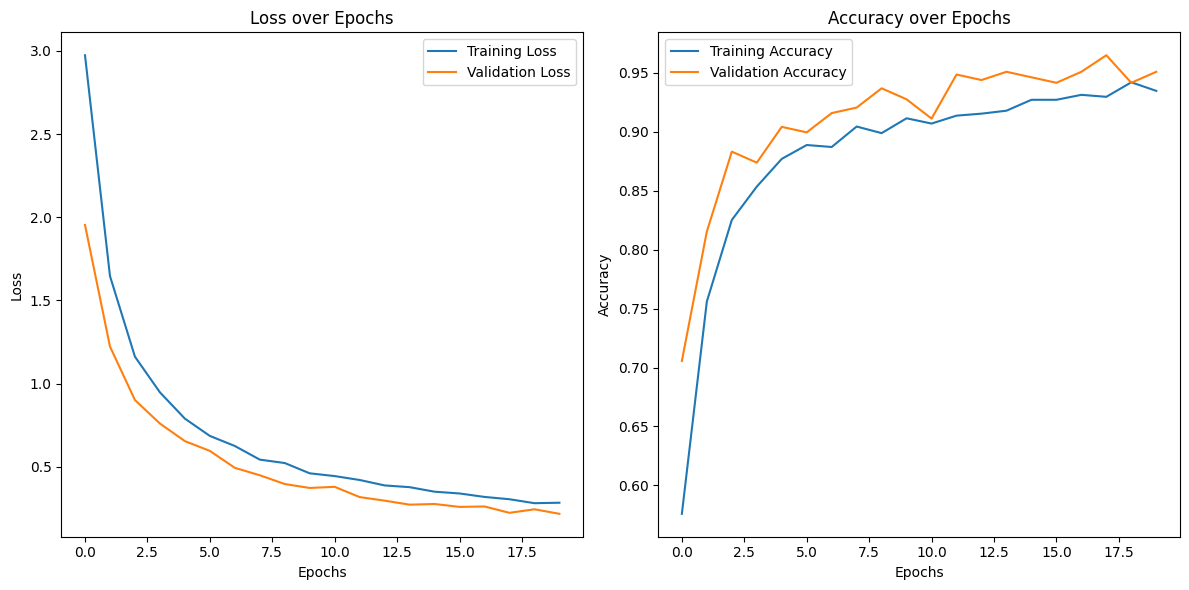

In [25]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
# import keras


# keras.saving.save_model(model, 'my_model.keras')


In [27]:
# model = tf.keras.models.load_model('my_model.keras')

In [46]:
img_path = 'test/cinder1.jpg'
# Load the image from file path
img = imageTf.load_img(img_path, target_size=(128, 128))

# Convert the image to a numpy array and expand dimensions to match input format
img_array = imageTf.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # This makes the shape (1, 224, 224, 3)

In [47]:
predictions = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [48]:
predicted_class = np.argmax(predictions, axis=-1)

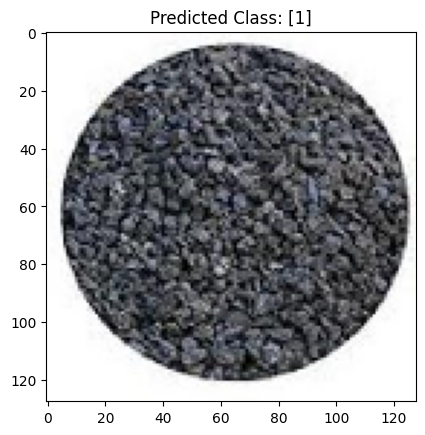

In [49]:
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class}')
plt.show()